In [18]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import cm
from pricer.pde_solver import ADICallPDE, ADIBarrierUpAndOutCallPDE, PDESolverConfig

colors = [x["color"] for x in list(plt.rcParams['axes.prop_cycle'])]

In [19]:
from neural_network.torch_model import PricerNetTorch
from neural_network.config import pipeline_configs

In [20]:
import math
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_call_price(S, K, T, r, sigma):
    """Price of a European call option using Black-Scholes formula."""
    if T <= 0 or sigma <= 0:
        return max(S - K, 0)
    
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put_price(S, K, T, r, sigma):
    return black_scholes_call_price(S, K, T, r, sigma) - S + K * np.exp(-r * T)

def implied_volatility(price, underlier_price, strike, expiry, interest_rate, tol=1e-6, max_iter=1000):
    """Compute implied volatility for a European call option using Brent's method."""
    
    def objective(sigma):
        return black_scholes_call_price(underlier_price, strike, expiry, interest_rate, sigma) - price
    
    try:
        # Use Brent's method to solve for the root
        implied_vol = brentq(objective, 0.01, 1.0, xtol=tol, maxiter=max_iter)
        return implied_vol
    except ValueError:
        return float('nan')

In [21]:
seed = 20250420
model_config = pipeline_configs["heston_call"].model

df = pd.read_csv(r"")

model_config.layer_number = 8 # df.iloc[0]["layer_number"]
model_config.neuron_per_layer = 64 # df.iloc[0]["neuron_per_layer"]
model_config.hidden_layer_activation = "gelu" # df.iloc[0]["hidden_layer_activation"]
model_config.learning_rate = 0.001 # df.iloc[0]["learning_rate"]
model_config.lambda_param = 1.0 # df.iloc[0]["lambda_param"]

model = PricerNetTorch(
    config={
            "input_variables": model_config.input_variables,
            "target_variables": model_config.target_variables,
            "layer_number": model_config.layer_number,
            "neuron_per_layer": model_config.neuron_per_layer,
            "activation_function": model_config.hidden_layer_activation,
            "learning_rate": model_config.learning_rate,
            "lambda_param": model_config.lambda_param,
            "calc_greek_regularization": True,
            "greek_weighting": False,
        }
)
model_path = os.path.join(r"", "saved_models", f"{seed}", f"ADICallPDE_{model_config.neuron_per_layer}_{model_config.layer_number}_{model_config.hidden_layer_activation}{'_greek_reg' if model_config.calc_greek_regularization else ''}{'_weighted' if model_config.greek_weighting and False else ''}{'_lambda_' + str(model_config.lambda_param) if model_config.lambda_param else ''}.model")

model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device("cpu")))

barrier_model_config = pipeline_configs["heston_uo_call"].model

# df = pd.read_csv(r"")

barrier_model_config.layer_number = 16 # df.iloc[0]["layer_number"]
barrier_model_config.neuron_per_layer = 96 # df.iloc[0]["neuron_per_layer"]
barrier_model_config.hidden_layer_activation = "gelu" # df.iloc[0]["hidden_layer_activation"]
barrier_model_config.learning_rate = 0.001 # df.iloc[0]["learning_rate"]
barrier_model_config.lambda_param = 0.01 # df.iloc[0]["lambda_param"]

barrier_model = PricerNetTorch(
    config={
            "input_variables": barrier_model_config.input_variables,
            "target_variables": barrier_model_config.target_variables,
            "layer_number": barrier_model_config.layer_number,
            "neuron_per_layer": barrier_model_config.neuron_per_layer,
            "activation_function": barrier_model_config.hidden_layer_activation,
            "learning_rate": barrier_model_config.learning_rate,
            "lambda_param": barrier_model_config.lambda_param,
            "calc_greek_regularization": True,
            "greek_weighting": False,
        }
)
barrier_model_path = os.path.join(r"", "saved_models", f"{seed}", f"ADIBarrierUpAndOutCallPDE_{barrier_model_config.neuron_per_layer}_{barrier_model_config.layer_number}_{barrier_model_config.hidden_layer_activation}{'_greek_reg' if barrier_model_config.calc_greek_regularization else ''}{'_weighted' if barrier_model_config.greek_weighting and False else ''}{'_lambda_' + str(barrier_model_config.lambda_param) if barrier_model_config.lambda_param else ''}.model")

barrier_model.load_state_dict(torch.load(barrier_model_path, weights_only=True, map_location=torch.device("cpu")))


implied_vol_model_config = pipeline_configs["implied_vol"].model

implied_vol_model_config.layer_number = 4 # df.iloc[0]["layer_number"]
implied_vol_model_config.neuron_per_layer = 16 # df.iloc[0]["neuron_per_layer"]
implied_vol_model_config.hidden_layer_activation = "tanh" # df.iloc[0]["hidden_layer_activation"]
implied_vol_model_config.learning_rate = 0.01 # df.iloc[0]["learning_rate"]
implied_vol_model_config.lambda_param = 0.001 # df.iloc[0]["lambda_param"]
implied_vol_model_config.calc_greek_regularization = True

implied_vol_model = PricerNetTorch(
    config={
            "input_variables": implied_vol_model_config.input_variables,
            "target_variables": implied_vol_model_config.target_variables,
            "layer_number": implied_vol_model_config.layer_number,
            "neuron_per_layer": implied_vol_model_config.neuron_per_layer,
            "activation_function": implied_vol_model_config.hidden_layer_activation,
            "learning_rate": implied_vol_model_config.learning_rate,
            "lambda_param": implied_vol_model_config.lambda_param,
            "calc_greek_regularization": True,
            "greek_weighting": False,
        }
)

implied_vol_model_path = os.path.join(r"", "saved_models", f"{seed}", f"ImpliedVol_{implied_vol_model_config.neuron_per_layer}_{implied_vol_model_config.layer_number}_{implied_vol_model_config.hidden_layer_activation}{'_greek_reg' if implied_vol_model_config.calc_greek_regularization else ''}{'_weighted' if implied_vol_model_config.greek_weighting and False else ''}{'_lambda_' + str(implied_vol_model_config.lambda_param) if implied_vol_model_config.lambda_param else ''}.model")

implied_vol_model.load_state_dict(torch.load(implied_vol_model_path, weights_only=True, map_location=torch.device("cpu")))


<All keys matched successfully>

In [22]:
def create_vanilla_market(vol_surface_config):
    market_data = []
    pricer = ADICallPDE(
        PDESolverConfig(
                    underlier_price_grid=np.array([]),
                    time_grid=np.linspace(0, 1.0, 201),
                    strike=1.0,
                    interest_rate=vol_surface_config["interest_rate"],
                    corr=vol_surface_config["corr"],
                    kappa=vol_surface_config["kappa"],
                    variance_theta=vol_surface_config["variance_theta"],
                    sigma=vol_surface_config["sigma"],
                    n=101,
                    m=101,
                    verbose=False,
                )
    )
    for expiry in [
        90/365, 120/365, 150/365, 180/365,
        210/365, 272/365, 365/365
    ]:
        for underlier_price in np.linspace(
            np.exp(-initial_state["interest_rate"]) - 0.15, 
            np.exp(-initial_state["interest_rate"]) + 0.15, 
            7
        ):
            instrument = vol_surface_config.copy()
            instrument.update(
                {
                    "underlier_price": underlier_price,
                    "expiry": expiry
                }
            )
            price = pricer.price([
                [vol_surface_config["initial_variance"], expiry, underlier_price]
            ])[0]
            
            implied_vol = implied_volatility(price, underlier_price, 1.0, expiry, vol_surface_config["interest_rate"])
            
            instrument.update({"price": price, "implied_vol": implied_vol})
            instrument.update({"log_time_value": np.log(
                np.maximum(1e-6, price - max(0.0, underlier_price - np.exp(-vol_surface_config["interest_rate"] * expiry)))
            )})
    
            market_data.append(instrument)
    market = pd.DataFrame(market_data)
    market["product"] = "vanilla"
    return market

def create_barrier_market(vol_surface_config):
    market_data = []
    for barrier, expiry in [
        (1.2, 180/365), (1.4, 300/365)
    ]:
        pricer = ADIBarrierUpAndOutCallPDE(
                PDESolverConfig(
                    underlier_price_grid=np.array([]),
                    time_grid=np.linspace(0, expiry, 101),
                    strike=1.0,
                    barrier=barrier,
                    interest_rate=vol_surface_config["interest_rate"],
                    corr=vol_surface_config["corr"],
                    kappa=vol_surface_config["kappa"],
                    variance_theta=vol_surface_config["variance_theta"],
                    sigma=vol_surface_config["sigma"],
                    n=101,
                    m=101,
                    verbose=False,
                )
            )
        for underlier_price in [1.05, 1.15]:
            instrument = vol_surface_config.copy()
            instrument.update(
                {
                    "underlier_price": underlier_price,
                    "expiry": expiry
                }
            )
            price = pricer.price([
                [vol_surface_config["initial_variance"], expiry, underlier_price]
            ])[0]
            
            instrument.update({"price": price, "barrier": barrier})
    
            market_data.append(instrument)
    market = pd.DataFrame(market_data)
    market["product"] = "barrier"
    return market

def create_market(vol_surface_config):
    vanilla_market = create_vanilla_market(vol_surface_config)
    barrier_market = create_barrier_market(vol_surface_config)
    market = pd.concat([vanilla_market, barrier_market], axis=0).reset_index(drop=True)
    market["strike"] = 1 / market["underlier_price"]
    return market

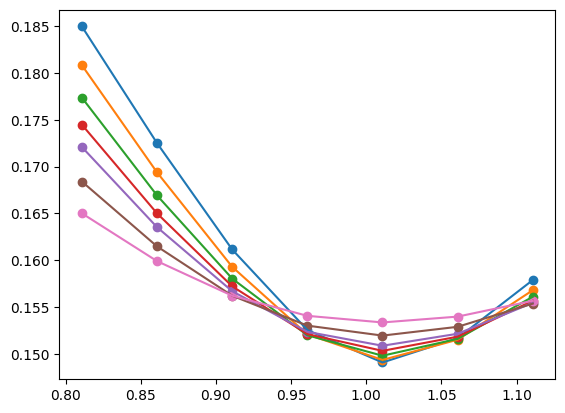

,initial_variance,interest_rate,corr,kappa,variance_theta,sigma,underlier_price,expiry,price,implied_vol,log_time_value,product,barrier,strike
0,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,0.810789,0.246575,0.000430,0.184958,-7.752474,vanilla,NaN,1.233366
1,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,0.860789,0.246575,0.001691,0.172504,-6.382455,vanilla,NaN,1.161724
2,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,0.910789,0.246575,0.005809,0.161144,-5.148274,vanilla,NaN,1.097949
3,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,0.960789,0.246575,0.017075,0.152548,-4.070152,vanilla,NaN,1.040811
4,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,1.010789,0.246575,0.040978,0.149081,-3.893504,vanilla,NaN,0.989326
5,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,1.060789,0.246575,0.078150,0.151678,-4.886792,vanilla,NaN,0.942694
6,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,1.110789,0.246575,0.123205,0.157885,-5.951745,vanilla,NaN,0.900261
7,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,0.810789,0.328767,0.001034,0.180822,-6.873949,vanilla,NaN,1.233366
8,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,0.860789,0.328767,0.003221,0.169378,-5.737951,vanilla,NaN,1.161724
9,0.023248,0.04,0.102367,3.444128,0.026533,0.437862,0.910789,0.328767,0.009029,0.159292,-4.707286,vanilla,NaN,1.097949


In [26]:
initial_state = {
    "initial_variance": (np.random.uniform(0.1, 0.25, 1) ** 2)[0],
    "interest_rate": 0.04,
    "corr": np.random.uniform(-0.3, 0.3, 1)[0],
    "kappa": np.random.uniform(1.0, 4.0, 1)[0],
    "variance_theta": (np.random.uniform(0.1, 0.25, 1) ** 2)[0],
    "sigma": np.random.uniform(0.3, 0.6, 1)[0],
}

market = create_market(initial_state)

for exp, exp_df in market.loc[market["product"] == "vanilla"].groupby("expiry"):
    plt.plot(exp_df["underlier_price"], exp_df["implied_vol"])
    plt.scatter(exp_df["underlier_price"], exp_df["implied_vol"])

plt.show()
market

In [27]:
implied_vol_cols = []
for c in implied_vol_model_config.input_variables:
    if c not in ["log_time_value"]:
        implied_vol_cols.append(c)
        if c not in market:
            market[c] = 0.0
    else:
        implied_vol_cols.append("model_" + c)
        if "model_" + c not in market:
            market["model_" + c] = 0.0

calib_column_map = {
    "initial_variance": 0,
    "corr": 1,
    "kappa": 2,
    "variance_theta": 3,
    "sigma": 4,
}

call_pricing_cols = []
for c in model_config.input_variables:
    if c not in calib_column_map:
        call_pricing_cols.append(c)
    else:
        call_pricing_cols.append("model_" + c)

barrier_pricing_cols = []
for c in barrier_model_config.input_variables:
    if c not in calib_column_map:
        barrier_pricing_cols.append(c)
    else:
        barrier_pricing_cols.append("model_" + c)

In [35]:
vanilla_market = market.loc[market["product"] == "vanilla"].copy()
barrier_market = market.loc[market["product"] == "barrier"].copy()

def calib_step(calib_params, calib_column_map, vanilla_market, barrier_market, loss="implied_vol"):
    for col_name, i in calib_column_map.items():
        vanilla_market.loc[:, "model_" + col_name] = calib_params[i]
        if loss == 'barrier':
            barrier_market.loc[:, "model_" + col_name] = calib_params[i]
    
    model_price = model(torch.tensor(vanilla_market[call_pricing_cols].values, dtype=torch.float32))
    vanilla_market.loc[:, "model_price"] = model_price.detach().numpy().flatten()
    vanilla_market.loc[:, "model_log_time_value"] = np.log(np.maximum(1e-4, vanilla_market["model_price"] - np.maximum(0, vanilla_market["underlier_price"] - np.exp(-vanilla_market["interest_rate"] * vanilla_market["expiry"]))))

    if loss == "barrier":
        barrier_model_price = barrier_model(torch.tensor(barrier_market[barrier_pricing_cols].values, dtype=torch.float32))
        barrier_market.loc[:, "model_price"] = barrier_model_price.detach().numpy().flatten()

    implied_vol = implied_vol_model(torch.tensor(vanilla_market[implied_vol_cols].values, dtype=torch.float32))
    vanilla_market.loc[:, "model_implied_vol"] = implied_vol.detach().numpy().flatten()

    if loss == "price":
        loss = torch.nn.MSELoss()(
            torch.tensor(vanilla_market[["price"]].values, dtype=torch.float32),
            model_price
        ).item()

    elif loss == 'implied_vol':
        loss = torch.nn.MSELoss()(
            torch.tensor(vanilla_market[["implied_vol"]].values, dtype=torch.float32),
            implied_vol
        ).item()
    else:
        loss = torch.nn.MSELoss()(
            torch.tensor(vanilla_market[["implied_vol"]].values, dtype=torch.float32),
            implied_vol
        ).item() + torch.nn.MSELoss()(
            torch.tensor(barrier_market[["price"]].values, dtype=torch.float32),
            barrier_model_price
        ).item()
    return loss

calib_step(
    np.array([0.04, -0.5, 1.5, 0.04, 0.1]),
    calib_column_map,
    vanilla_market=vanilla_market,
    barrier_market=barrier_market
)

0.001764693413861096

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 316
         Function evaluations: 534
Kalibráció elvégezve 5.6581 mp alatt
initial_variance: 0.0222, 	valódi paraméter: 0.0232
corr: 0.1275, 	valódi paraméter: 0.1024
kappa: 3.2494, 	valódi paraméter: 3.4441
variance_theta: 0.0251, 	valódi paraméter: 0.0265
sigma: 0.1503, 	valódi paraméter: 0.4379


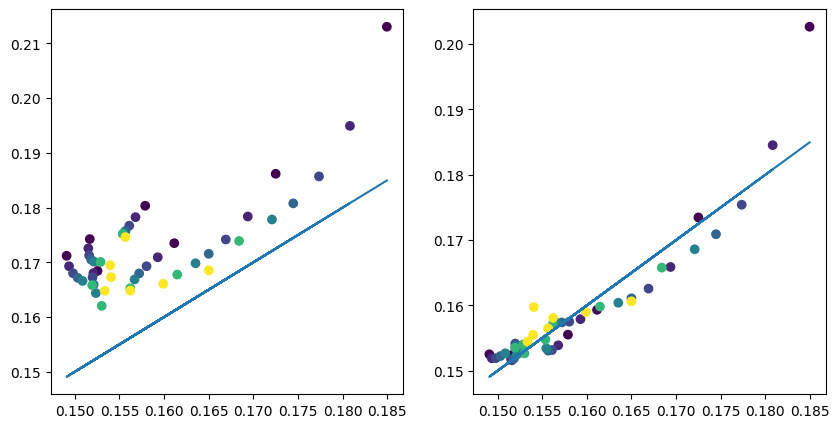

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.73it/s]


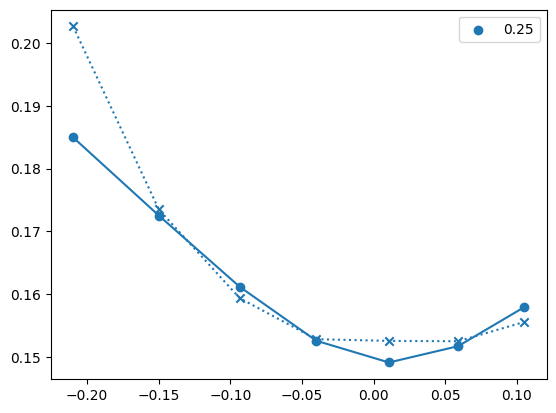

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.26it/s]


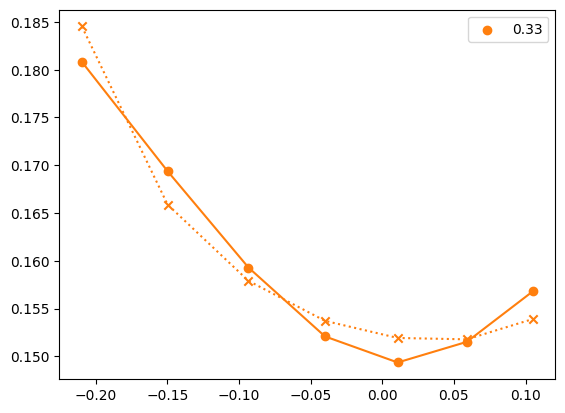

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.46it/s]


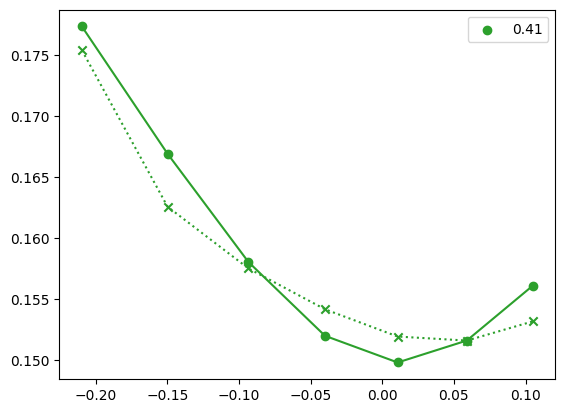

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.75it/s]


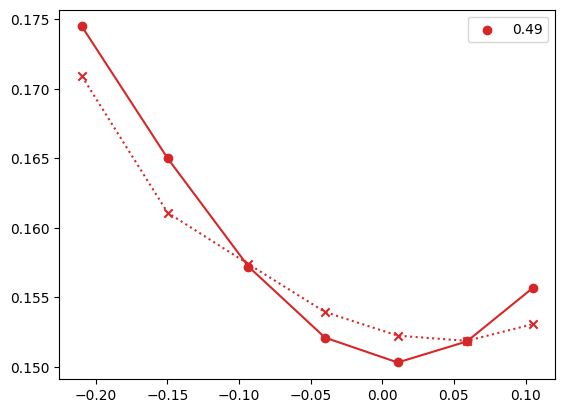

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.54it/s]


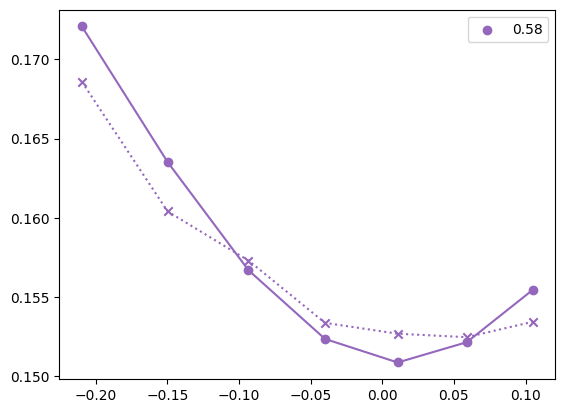

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.38it/s]


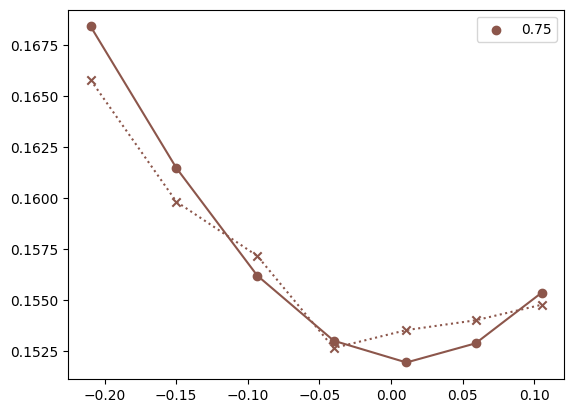

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.44it/s]


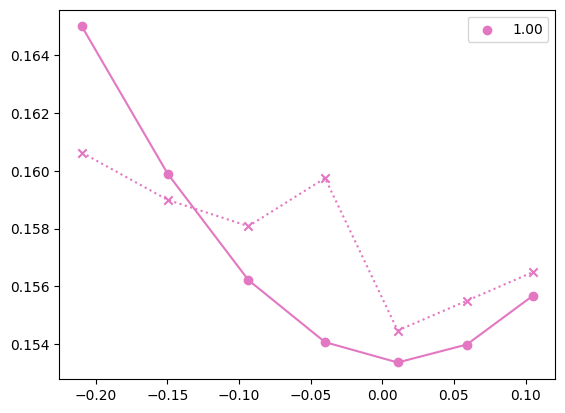

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

init_guess = np.array([
    (np.random.uniform(0.15, 0.20, 1) ** 2)[0],
    np.random.uniform(-0.25, 0.15, 1)[0],
    np.random.uniform(2.0, 3.0, 1)[0],
    (np.random.uniform(0.15, 0.20, 1) ** 2)[0],
    np.random.uniform(0.3, 0.6, 1)[0],
])

calib_step(init_guess, calib_column_map, vanilla_market, barrier_market)

# ax[0].scatter(market["price"], market["model_price"], c=market["expiry"])
# ax[0].plot(market["price"], market["price"])

market = pd.concat([vanilla_market, barrier_market], axis=0).reset_index(drop=True)

ax[0].scatter(market["implied_vol"], market["model_implied_vol"], c=market["expiry"])
ax[0].plot(market["implied_vol"], market["implied_vol"])

s = time.perf_counter()

bounds = [(0.005, 0.1), (-1.0, 1.0), (1.0, None), (0.01, 0.1), (0.1, None)]
calibrated_params = minimize(
    lambda x: calib_step(x, calib_column_map, vanilla_market, barrier_market, loss="implied_vol"),
    # lambda x: calib_step_fast(x, calib_column_map, vanilla_market, barrier_market, loss="implied_vol"),
    init_guess,
    method="Nelder-Mead",
    # method="SLSQP",
    # bounds=bounds,
    options={
        # 'xatol': 1e-3,
        'disp': True,
    }
).x

print(f"Kalibráció elvégezve {time.perf_counter() - s:.4f} mp alatt")

market = pd.concat([vanilla_market, barrier_market], axis=0).reset_index(drop=True)

for param_name, i in calib_column_map.items():
    print(f"{param_name}: {calibrated_params[i]:.4f}, \tvalódi paraméter: {market.iloc[0][param_name]:.4f}")

# ax[1].scatter(market["price"], market["model_price"], c=market["expiry"])
# ax[1].plot(market["price"], market["price"])

ax[1].scatter(market["implied_vol"], market["model_implied_vol"], c=market["expiry"])
ax[1].plot(market["implied_vol"], market["implied_vol"])

plt.show()

implied_vol = implied_vol_model(torch.tensor(market.loc[market["product"] == "vanilla", implied_vol_cols].values, dtype=torch.float32)) # implied_volatility(row["model_price"], row["underlier_price"], 1.0, row["expiry"], initial_state["interest_rate"])
market.loc[market["product"] == "vanilla", "model_implied_vol"] = implied_vol.detach().numpy()

for i, (exp, exp_df) in enumerate(market.loc[market["product"] == "vanilla"].groupby("expiry")):
    pricer = ADICallPDE(
        PDESolverConfig(
            underlier_price_grid=np.array([]),
            time_grid=np.linspace(0, exp, 101),
            strike=1.0,
            interest_rate=exp_df.iloc[0]["interest_rate"],
            corr=exp_df.iloc[0]["model_corr"],
            kappa=exp_df.iloc[0]["model_kappa"],
            variance_theta=exp_df.iloc[0]["model_variance_theta"],
            sigma=exp_df.iloc[0]["model_sigma"],
            n=101,
            m=101,
        )
    )
    price = pricer.price(exp_df[["model_initial_variance", "expiry", "underlier_price"]].values)
    exp_df["model_param_price"] = price

    for _, row in exp_df.iterrows():
        implied_vol = implied_volatility(row["model_param_price"], row["underlier_price"], 1.0, row["expiry"], initial_state["interest_rate"])
        exp_df.loc[_, "model_param_implied_vol"] = implied_vol
    
    plt.plot(np.log(exp_df["underlier_price"]), exp_df["implied_vol"], c=colors[i])
    plt.scatter(np.log(exp_df["underlier_price"]), exp_df["implied_vol"], c=colors[i], label=f"{exp:.2f}")

    plt.plot(np.log(exp_df["underlier_price"]), exp_df["model_implied_vol"], linestyle=":", c=colors[i])
    plt.scatter(np.log(exp_df["underlier_price"]), exp_df["model_implied_vol"], marker="x", c=colors[i])
    
    # plt.plot(np.log(exp_df["underlier_price"]), exp_df["model_param_implied_vol"], linestyle="-.", c=colors[i])
    # plt.scatter(np.log(exp_df["underlier_price"]), exp_df["model_param_implied_vol"], marker="v", c=colors[i])

    plt.legend()
    plt.show()

# Performance

In [37]:
def calib_step_fast(calib_params, calib_column_map, vanilla_market, barrier_market, loss="implied_vol"):
    # Convert only once
    vanilla_array = torch.tensor(vanilla_market[call_pricing_cols].values, dtype=torch.float32)
    barrier_array = torch.tensor(barrier_market[barrier_pricing_cols].values, dtype=torch.float32)
    vanilla_prices = torch.tensor(vanilla_market["price"].values, dtype=torch.float32).unsqueeze(1)
    barrier_prices = torch.tensor(barrier_market["price"].values, dtype=torch.float32).unsqueeze(1)
    vanilla_implied = torch.tensor(vanilla_market["implied_vol"].values, dtype=torch.float32).unsqueeze(1)

    # Update parameters in a single pass
    for col_name, i in calib_column_map.items():
        # vanilla_market.loc[:, "model_" + col_name] = calib_params[i]
        vanilla_array[:, call_pricing_cols.index("model_" + col_name)] = calib_params[i]
        if loss == "barrier":
            # barrier_market.loc[:, "model_" + col_name] = calib_params[i]
            barrier_array[:, barrier_pricing_cols.index("model_" + col_name)] = calib_params[i]

    # Compute forward pass for vanilla model
    model_price = model(vanilla_array)
    vanilla_market["model_price"] = model_price.detach().numpy().flatten()

    # Compute log of time value
    s = vanilla_market["underlier_price"].values
    disc = np.exp(-vanilla_market["interest_rate"].values * vanilla_market["expiry"].values)
    vanilla_market["model_log_time_value"] = np.log(
        np.maximum(1e-5, vanilla_market["model_price"] - np.maximum(0, s - disc))
    )

    # Barrier branch
    if loss == "barrier":
        barrier_model_price = barrier_model(barrier_array)
        barrier_market["model_price"] = barrier_model_price.detach().numpy().flatten()

    # Implied vol computation
    implied_vol_values = implied_vol_model(
        torch.tensor(vanilla_market[implied_vol_cols].values, dtype=torch.float32)
    )
    vanilla_market["model_implied_vol"] = implied_vol_values.detach().numpy().flatten()

    # Compute loss terms efficiently in PyTorch
    if loss == "price":
        return torch.nn.functional.mse_loss(vanilla_prices, model_price).item()
    elif loss == "implied_vol":
        return torch.nn.functional.mse_loss(vanilla_implied, implied_vol_values).item()
    else:
        lv = torch.nn.functional.mse_loss(vanilla_implied, implied_vol_values)
        lb = torch.nn.functional.mse_loss(barrier_prices, barrier_model_price)
        return (lv + lb).item()

In [120]:
concat_list = []

for test_case in range(100):
    print(test_case)
    initial_state = {
        "initial_variance": (np.random.uniform(0.1, 0.25, 1) ** 2)[0],
        "interest_rate": 0.03,
        "corr": np.random.uniform(-0.3, 0.3, 1)[0],
        "kappa": np.random.uniform(1.0, 4.0, 1)[0],
        "variance_theta": (np.random.uniform(0.1, 0.25, 1) ** 2)[0],
        "sigma": np.random.uniform(0.3, 0.6, 1)[0],
    }
    
    market = create_market(initial_state)
    init_cols = market.columns

    init_guess = np.array([
        (np.random.uniform(0.15, 0.20, 1) ** 2)[0],
        np.random.uniform(-0.25, 0.15, 1)[0],
        np.random.uniform(2.0, 3.0, 1)[0],
        (np.random.uniform(0.15, 0.20, 1) ** 2)[0],
        np.random.uniform(0.3, 0.6, 1)[0],
    ])

    for loss in ["price", "implied_vol", "barrier"]:
        vanilla_market = market.loc[market["product"] == "vanilla", init_cols].copy()
        barrier_market = market.loc[market["product"] == "barrier", init_cols].copy()
        calib_step(init_guess, calib_column_map, vanilla_market, barrier_market, loss="barrier")
        
        s = time.perf_counter()
        
        bounds = [(0.005, 0.1), (-1.0, 1.0), (1.0, None), (0.01, 0.1), (0.1, None)]
        calibrated_params = minimize(
            lambda x: calib_step_fast(x, calib_column_map, vanilla_market, barrier_market, loss=loss),
            init_guess,
            method="Nelder-Mead",
            # bounds=bounds,
        ).x
        e = time.perf_counter() - s
        print(test_case, loss, e)
        market = pd.concat([vanilla_market, barrier_market], axis=0).reset_index(drop=True)
        for col_name, i in calib_column_map.items():
            market.loc[:, "model_" + col_name] = calibrated_params[i]
        market["loss_type"] = loss
        market["calib_time"] = e
        market["idx"] = test_case

        concat_list.append(market)
df = pd.concat(concat_list, axis=0).reset_index(drop=True)
df.to_csv("calib_no_bounds.csv")

0
0 price 5.0665232000174
0 implied_vol 3.3240659999428317
0 barrier 5.327606400009245
1
1 price 2.499007700011134
1 implied_vol 2.4064609999768436
1 barrier 3.4184990000212565
2
2 price 2.4635965999914333
2 implied_vol 3.895131799974479
2 barrier 3.0901392000960186
3
3 price 2.3834129999158904
3 implied_vol 2.629249299992807
3 barrier 3.735706500010565
4
4 price 1.8142493000486866
4 implied_vol 3.163882900029421
4 barrier 3.9515576000558212
5
5 price 2.92603779991623
5 implied_vol 3.247265600017272
5 barrier 4.4447911999886855
6
6 price 4.388387399958447
6 implied_vol 4.839417799958028
6 barrier 6.061636400059797
7
7 price 2.373118199990131
7 implied_vol 3.0197041999781504
7 barrier 3.2157705000136048
8
8 price 1.9210713000502437
8 implied_vol 2.3226744999410585
8 barrier 5.061037299921736
9
9 price 3.9056494999676943
9 implied_vol 4.794880900066346
9 barrier 8.256934399949387
10
10 price 4.03463649994228
10 implied_vol 2.92222980002407
10 barrier 3.0347248000325635
11
11 price 4.6732

In [121]:
df = pd.read_csv("calib_no_bounds.csv", index_col=[0])
df

,initial_variance,interest_rate,corr,kappa,variance_theta,sigma,underlier_price,expiry,price,implied_vol,...,model_corr,model_kappa,model_variance_theta,model_sigma,model_price,model_log_time_value,model_implied_vol,loss_type,calib_time,idx
0,0.057645,0.03,-0.295181,3.303307,0.056853,0.55271,0.820446,0.246575,0.001879,0.226442,...,-0.321073,0.513772,0.059308,0.502039,0.002103,-6.164269,0.232321,price,5.066523,0
1,0.057645,0.03,-0.295181,3.303307,0.056853,0.55271,0.870446,0.246575,0.005990,0.223619,...,-0.321073,0.513772,0.059308,0.502039,0.006154,-5.090620,0.225707,price,5.066523,0
2,0.057645,0.03,-0.295181,3.303307,0.056853,0.55271,0.920446,0.246575,0.015798,0.224449,...,-0.321073,0.513772,0.059308,0.502039,0.016114,-4.128072,0.225217,price,5.066523,0
3,0.057645,0.03,-0.295181,3.303307,0.056853,0.55271,0.970446,0.246575,0.034204,0.228568,...,-0.321073,0.513772,0.059308,0.502039,0.034602,-3.363847,0.229842,price,5.066523,0
4,0.057645,0.03,-0.295181,3.303307,0.056853,0.55271,1.020446,0.246575,0.062135,0.235464,...,-0.321073,0.513772,0.059308,0.502039,0.062342,-3.366031,0.237255,price,5.066523,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15895,0.014754,0.03,0.071621,2.280261,0.014800,0.39729,1.120446,1.000000,0.157452,0.121988,...,0.129346,2.919785,0.013678,0.118066,0.157145,-4.941289,0.120289,barrier,4.232165,99
15896,0.014754,0.03,0.071621,2.280261,0.014800,0.39729,1.050000,0.493151,0.051082,NaN,...,0.129346,2.919785,0.013678,0.118066,0.056337,NaN,NaN,barrier,4.232165,99
15897,0.014754,0.03,0.071621,2.280261,0.014800,0.39729,1.150000,0.493151,0.055208,NaN,...,0.129346,2.919785,0.013678,0.118066,0.062087,NaN,NaN,barrier,4.232165,99
15898,0.014754,0.03,0.071621,2.280261,0.014800,0.39729,1.050000,0.821918,0.078207,NaN,...,0.129346,2.919785,0.013678,0.118066,0.084351,NaN,NaN,barrier,4.232165,99


In [122]:
from sklearn.metrics import r2_score

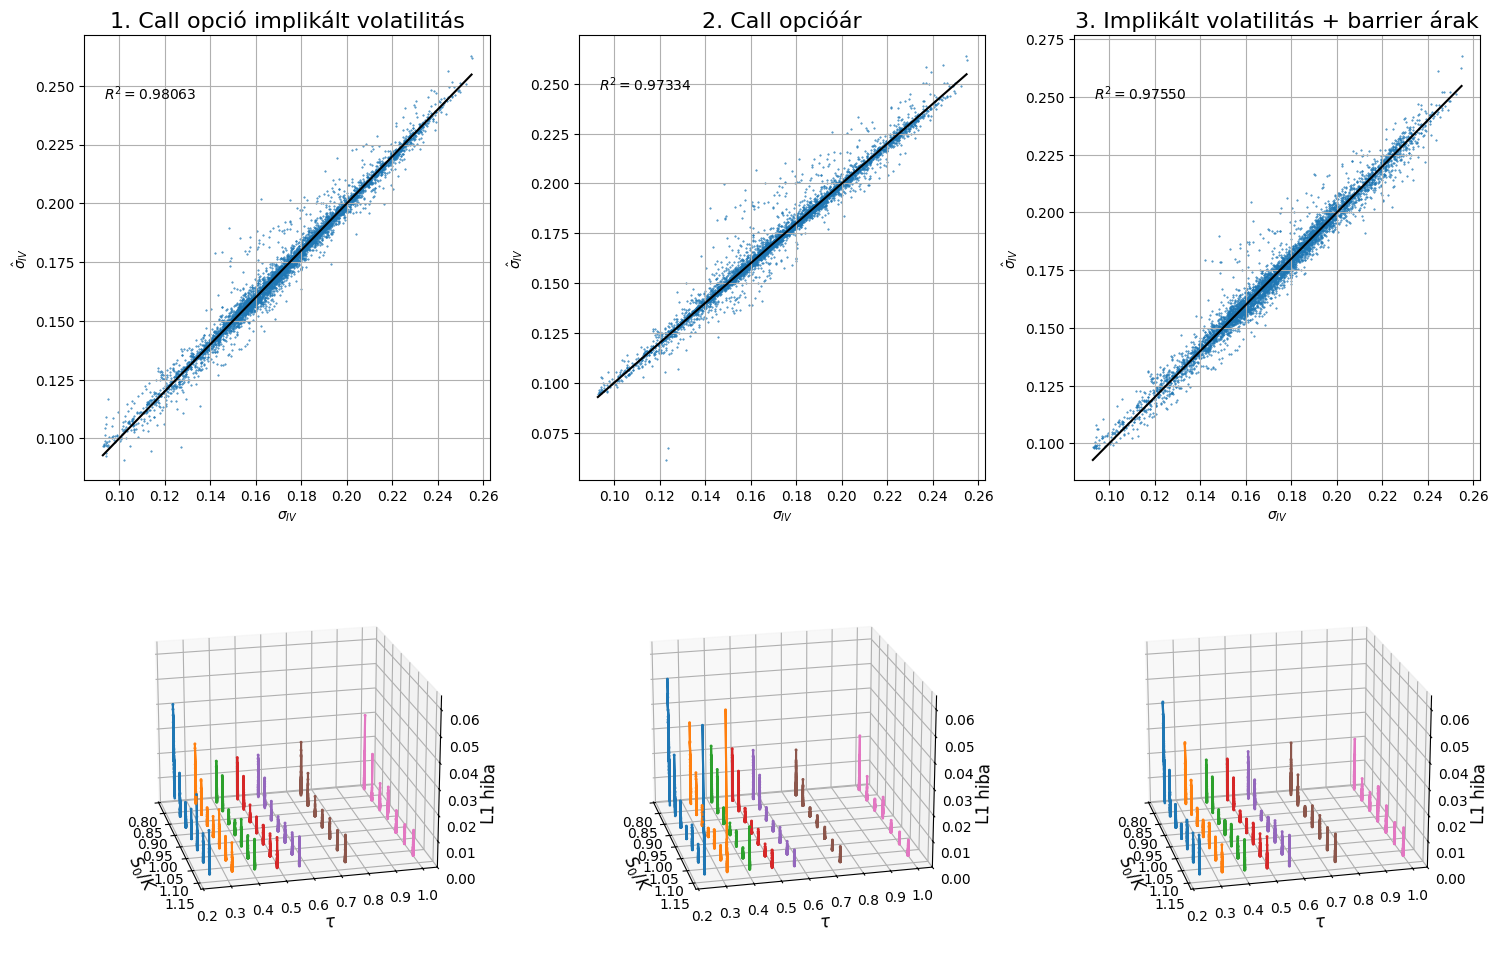

In [132]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
[x.grid(True) for x in ax.flatten()]

title_map = {"implied_vol": "1. Call opció implikált volatilitás",
            "price": "2. Call opcióár",
            "barrier": "3. Implikált volatilitás + barrier árak"
            }
for i, loss_type in enumerate(["implied_vol", "price", "barrier"]):
    impl_vol = df.loc[df["loss_type"] == loss_type, "implied_vol"]
    model_impl_vol = df.loc[df["loss_type"] == loss_type, "model_implied_vol"]
    ax[0][i].scatter(impl_vol, model_impl_vol, s=0.2)
    ax[0][i].plot([impl_vol.min(), impl_vol.max()], [impl_vol.min(), impl_vol.max()], color="black")
    
    rsquared = r2_score(df.loc[(df["loss_type"] == loss_type) & (df["product"] == "vanilla"), "implied_vol"], df.loc[(df["loss_type"] == loss_type)  & (df["product"] == "vanilla"), "model_implied_vol"])
    ax[0][i].text(ax[0][i].get_xlim()[0] * 1.1, ax[0][i].get_ylim()[1] * 0.9, fr"$R^2={rsquared:.5f}$")
    ax[0][i].set_title(title_map[loss_type], fontsize=16)
    ax[0][i].set_xlabel(r"$\sigma_{IV}$")
    ax[0][i].set_ylabel(r"$\hat{\sigma}_{IV}$")
    
    ax[1, i].remove()  # Remove the 2D axes
    ax3d = fig.add_subplot(2, 3, 4 + i, projection='3d')
    # ax3d.scatter(df.loc[df["loss_type"] == loss_type, "underlier_price"], df.loc[df["loss_type"] == loss_type, "expiry"], (impl_vol - model_impl_vol).abs(), c=df.loc[df["loss_type"] == loss_type, "expiry"])

    color_map = {val: colors[i] for i, val in enumerate(df["expiry"].unique())}
    for (s, e), sub_df in df.loc[df["loss_type"] == loss_type].groupby(["underlier_price", "expiry"]):
        ax3d.plot([s] * sub_df.shape[0], [e] * sub_df.shape[0], (sub_df["implied_vol"] - sub_df["model_implied_vol"]).abs(), color=color_map[e])
        ax3d.scatter([s] * sub_df.shape[0], [e] * sub_df.shape[0], (sub_df["implied_vol"] - sub_df["model_implied_vol"]).abs(), color=color_map[e], s=1.25)
    ax3d.set(zlim=(0.0, 0.065))
    ax3d.view_init(20, -13.25)
    ax3d.set_box_aspect(None, zoom=0.9)
    ax3d.set_xlabel(r"$S_0/K$", fontsize=12)
    ax3d.set_ylabel(r"$\tau$", fontsize=12)
    ax3d.set_zlabel(r"L1 hiba", fontsize=12)
plt.tight_layout()
plt.savefig("heston-calib-error.png")
plt.show()

In [135]:
df[["loss_type", "calib_time"]].groupby("loss_type").mean()

,calib_time
loss_type,
barrier,4.371830
implied_vol,3.198700
price,3.412661


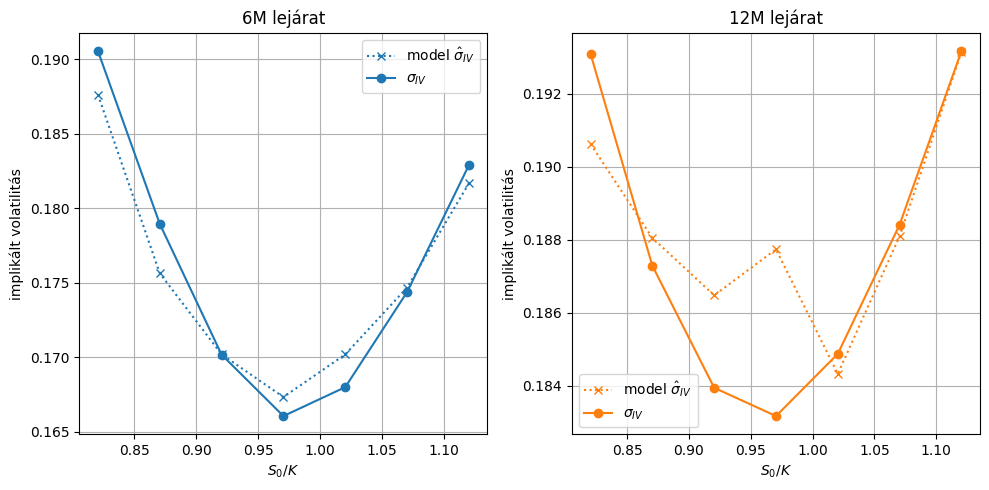

In [191]:
idx = 77

short_df = df.loc[(df["loss_type"] == "implied_vol") & (df["idx"] == idx) & (df["expiry"] == 180/365)]
long_df = df.loc[(df["loss_type"] == "implied_vol") & (df["idx"] == idx) & (df["expiry"] == 1.0)]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
[x.grid(True) for x in ax.flatten()]

ax[0].plot(short_df["underlier_price"], short_df["model_implied_vol"], color=colors[0], linestyle="dotted", marker="x", label=r"model $\hat{\sigma}_{IV}$")
ax[0].plot(short_df["underlier_price"], short_df["implied_vol"], color=colors[0], marker="o", label=r"$\sigma_{IV}$")
ax[0].legend()
ax[0].set_xlabel(r"$S_0/K$")
ax[0].set_ylabel("implikált volatilitás")
ax[0].set_title("6M lejárat", fontsize=12)

ax[1].plot(long_df["underlier_price"], long_df["model_implied_vol"], color=colors[1], linestyle="dotted", marker="x", label=r"model $\hat{\sigma}_{IV}$")
ax[1].plot(long_df["underlier_price"], long_df["implied_vol"], color=colors[1], marker="o", label=r"$\sigma_{IV}$")
ax[1].legend()
ax[1].set_xlabel(r"$S_0/K$")
ax[1].set_ylabel("implikált volatilitás")
ax[1].set_title("12M lejárat", fontsize=12)

plt.tight_layout()
plt.savefig("heston-calib-bad-extrapolation.png")
plt.show()

In [203]:
error_dict = {}
latex_dict = {"initial_variance": r"$V_0$",
             "corr": r"$\rho$",
             "kappa": r"$\kappa$",
             "variance_theta": r"$\theta$",
             "sigma": r"$\sigma$"}
for col in ["initial_variance", "corr", "kappa", "variance_theta", "sigma"]:
    l1_error = (df.loc[(df["loss_type"] == "implied_vol"), col] - df.loc[(df["loss_type"] == "implied_vol"), f"model_{col}"]).abs().mean()
    # l2_error = ((df.loc[(df["loss_type"] == "implied_vol"), col] - df.loc[(df["loss_type"] == "implied_vol"), f"model_{col}"]) ** 2).mean()

    error_dict[latex_dict[col]] = [
        l1_error,
        # l2_error
    ]

pd.DataFrame(error_dict, index=[
    r"átlagos $L1$ hiba",
    # r"átlagos $L2$ hiba"
]).style.format("{:.4f}").set_table_styles(
    {col: [{'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '12pt')]},
          {'selector': 'td', 'props': [('text-align', 'right'), ('font-size', '10pt')]}] for col in df},
    overwrite=False
).set_table_styles(
    [
        {'selector': 'th.row_heading', 'props': [('font-size', '12pt')]},  # row index
        {'selector': 'th.col_heading', 'props': [('font-size', '10pt')]},  # optional: column headers
    ],
    overwrite=False
)

,$V_0$,$\rho$,$\kappa$,$\theta$,$\sigma$
átlagos $L1$ hiba,0.0030,0.1458,1.1402,0.0043,0.2822
